In [1]:
#%%
from collections import defaultdict
from sklearn import metrics
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# new helpers:
from shared import (
    dataset_local_path,
)

# stdlib:
from dataclasses import dataclass, field
import json
from typing import List, DefaultDict

In [3]:
#%% load up the data
examples = []
ys = []

##
# Notice that we're using hand-designed features here, not text features:
##

with open(dataset_local_path("poetry_id.jsonl")) as fp:
    for line in fp:
        info = json.loads(line)
        # Note: the data contains a whole bunch of extra stuff; we just want numeric features for now.
        keep = info["features"]
        # whether or not it's poetry is our label.
        ys.append(info["poetry"])
        # hold onto this single dictionary.
        examples.append(keep)

## CONVERT TO MATRIX:

feature_numbering = DictVectorizer(sort=True, sparse=False)
X = feature_numbering.fit_transform(examples)

print("Features as {} matrix.".format(X.shape))


## SPLIT DATA:

RANDOM_SEED = 12345678

# Numpy-arrays are more useful than python's lists.
y = np.array(ys)
# split off train/validate (tv) pieces.
rX_tv, rX_test, y_tv, y_test = train_test_split(
    X, y, train_size=0.75, shuffle=True, random_state=RANDOM_SEED
)
# split off train, validate from (tv) pieces.
rX_train, rX_vali, y_train, y_vali = train_test_split(
    rX_tv, y_tv, train_size=0.66, shuffle=True, random_state=RANDOM_SEED
)

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# TODO: Exploration 2: What normalization is best for your models?
# THINK: Why didn't we normalize for decision trees?
#
# These are the three approaches to scaling I see in practice: variance / standard-deviation, min/max, nothing.
# This replaces the X / 1000 hack we did a few weeks ago.
norm = "max"
if norm == "var":
    scale = StandardScaler()
    X_train = scale.fit_transform(rX_train)
    X_vali = scale.transform(rX_vali)
    X_test = scale.transform(rX_test)
elif norm == "max":
    scale = MinMaxScaler()
    X_train = scale.fit_transform(rX_train)
    X_vali = scale.transform(rX_vali)
    X_test = scale.transform(rX_test)
else:
    X_train = rX_train
    X_vali = rX_vali
    X_test = rX_test

print(X_train.shape, X_vali.shape, X_test.shape)

# Delete these generic variables that we really shouldn't use anymore now that the data is fully-prepared.
del X, y, ys, rX_train, rX_vali, rX_test

Features as (2772, 38) matrix.
(1372, 38) (707, 38) (693, 38)


In [4]:
#%% Define and Train Models


@dataclass
class LinearModel:
    weights: np.ndarray  # note we can't specify this is 1-dimensional
    bias: float = 0.0

    def decision_function(self, X: np.ndarray) -> np.ndarray:
        """ Compute the signed distance from the self.weights hyperplane. """
        (N, D) = X.shape
        assert self.weights.shape == (D, 1)
        # Matrix multiplication; sprinkle transpose and assert to get the shapes you want (or remember Linear Algebra)... or both!
        output = np.dot(self.weights.transpose(), X.transpose())
        assert output.shape == (1, N)
        return (output + self.bias).reshape((N,))

    def predict(self, X: np.ndarray) -> np.ndarray:
        """ Take whether the points are above or below our hyperplane as a prediction. """
        return self.decision_function(X) > 0

    def score(self, X: np.ndarray, y: np.ndarray) -> float:
        """ Take predictions and compute accuracy. """
        y_hat = self.predict(X)
        return metrics.accuracy_score(np.asarray(y), y_hat)

    def compute_auc(self, X: np.ndarray, y: np.ndarray) -> float:
        """ Distance to hyperplane is used for AUC-style metrics. """
        return metrics.roc_auc_score(y, self.decision_function(X))


@dataclass
class ModelTrainingCurve:
    train: List[float] = field(default_factory=list)
    validation: List[float] = field(default_factory=list)

    def add_sample(
        self,
        m: LinearModel,
        X: np.ndarray,
        y: np.ndarray,
        X_vali: np.ndarray,
        y_vali: np.ndarray,
    ) -> None:
        self.train.append(m.score(X, y))
        self.validation.append(m.score(X_vali, y_vali))


# These are the named lines that will be plotted:
learning_curves: DefaultDict[str, ModelTrainingCurve] = defaultdict(ModelTrainingCurve)


def train_perceptron(y, X, y_vali, X_vali, num_iter=100, seed=1231) -> LinearModel:
    rand = np.random.default_rng(seed)
    (num_examples, num_features) = X.shape
    assert len(y) == num_examples
    w = np.zeros((num_features, 1))
    b = 0.0
    indices = list(range(num_examples))
    for iteration in range(num_iter):
        rand.shuffle(indices)
        wrong = 0
        for i in indices:
            if y[i]:
                y_val = 1
            else:
                y_val = -1

            x_i = X[i, :].reshape((num_features, 1))

            activation = np.dot(w.transpose(), x_i) + b
            if y[i] != (activation > 0):
                wrong += 1
                # we got it wrong! update!
                w += y_val * x_i
                b += y_val
        if wrong == 0:
            break
        tmp = LinearModel(w, b)
        learning_curves["Perceptron"].add_sample(tmp, X, y, X_vali, y_vali)
    return LinearModel(w, b)


def train_averaged_perceptron(
    y, X, y_vali, X_vali, num_iter=100, seed=1231
) -> LinearModel:
    rand = np.random.default_rng(seed)
    (num_examples, num_features) = X.shape
    assert len(y) == num_examples
    w_avg = np.zeros((num_features, 1))
    b_avg = 0.0
    w = np.zeros((num_features, 1))
    b = 0.0
    current_correct = 0
    indices = list(range(num_examples))
    for iteration in range(num_iter):
        rand.shuffle(indices)
        wrong = 0
        for i in indices:
            if y[i]:
                y_val = 1
            else:
                y_val = -1

            x_i = X[i, :].reshape((num_features, 1))

            activation = np.dot(w.transpose(), x_i) + b
            if y[i] != (activation > 0):
                # update 'average' vector:
                w_avg += current_correct * w
                b_avg += current_correct * b
                current_correct = 0
                # update 'current' vector
                wrong += 1
                # we got it wrong! update!
                w += y_val * x_i
                b += y_val
            else:
                current_correct += 1
        if wrong == 0:
            break
        tmp = LinearModel(w_avg, b_avg)
        learning_curves["Averaged-Perceptron"].add_sample(tmp, X, y, X_vali, y_vali)
    return LinearModel(w_avg, b_avg)


model = train_perceptron(y_train, X_train, y_vali, X_vali, num_iter=1000)
print("P. Train-Accuracy: {:.3}".format(model.score(X_train, y_train)))
print("P. Vali-Accuracy: {:.3}".format(model.score(X_vali, y_vali)))

model = train_averaged_perceptron(y_train, X_train, y_vali, X_vali, num_iter=1000)
print("AP. Train-Accuracy: {:.3}".format(model.score(X_train, y_train)))
print("AP. Vali-Accuracy: {:.3}".format(model.score(X_vali, y_vali)))

# Note that Sci-Kit Learn's Perceptron uses an alternative method of training.
# Is it an averaged perceptron or a regular perceptron?
skP = Perceptron()
print("Train sklearn-Perceptron (skP)")
for iter in tqdm(range(1000)):
    # Note we use partial_fit rather than fit to expose the loop to our code!
    skP.partial_fit(X_train, y_train, classes=(0, 1))
    learning_curves["skPerceptron"].add_sample(skP, X_train, y_train, X_vali, y_vali)
print("skP. Train-Accuracy: {:.3}".format(skP.score(X_train, y_train)))
print("skP. Vali-Accuracy: {:.3}".format(skP.score(X_vali, y_vali)))

P. Train-Accuracy: 0.929
P. Vali-Accuracy: 0.936


 15%|█▌        | 150/1000 [00:00<00:01, 720.15it/s]

AP. Train-Accuracy: 0.94
AP. Vali-Accuracy: 0.941
Train sklearn-Perceptron (skP)


100%|██████████| 1000/1000 [00:01<00:00, 809.12it/s]

skP. Train-Accuracy: 0.921
skP. Vali-Accuracy: 0.915


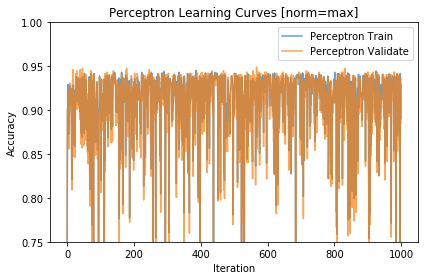

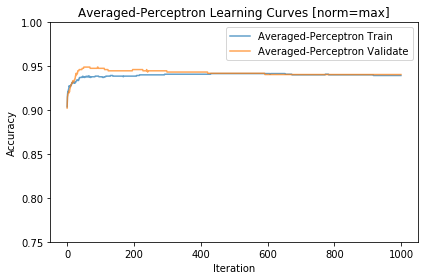

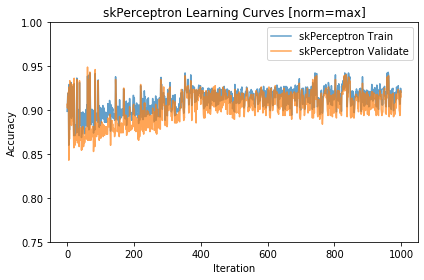

In [5]:

#

mlp = MLPClassifier(hidden_layer_sizes=(32,))

sgdc = SGDClassifier()

#%% Plot!

#
# This is the first time we're seeing how to make a line plot.
# Also the first time we're creating plots in a loop! (Gets too busy if they're all on the same chart, IMO)
# Matplotlib *does* have subplots, but they're so fiddly.
#
for key, dataset in learning_curves.items():
    xs = np.array(list(range(len(dataset.train))))
    # line-plot:
    plt.plot(xs, dataset.train, label="{} Train".format(key), alpha=0.7)
    plt.plot(xs, dataset.validation, label="{} Validate".format(key), alpha=0.7)
    # scatter-plot: (maybe these look nicer to you?)
    # plt.scatter(xs, points, label=key, alpha=0.7, marker=".")
    plt.ylim((0.75, 1.0))
    plt.title("{} Learning Curves [norm={}]".format(key, norm))
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.savefig("graphs/p07-{}-curve-{}.png".format(key, norm))
    plt.show()

## TODO Exploration 1: use a loop around partial-fit to generate another graph!

## TODO Exploration 1A: Try a MLP (Multi-Layer Perceptron).

## TODO Exploration 1B: Try another Linear Model

## TODO Think: Why can't we make a graph like this for DecisionTreeClassifier?